In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-09 07:18:35.508935: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 07:18:36.014194: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-09 07:18:37.758631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_130


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:40<00:00,  1.01s/it]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
29,-89.259064,0.057546,0.057546,-10.070161,0.029858,0.000262,0.104063,837.5,0.0,47637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.457848,0.147454,0.147454,-0.726222,0.029458,0.000533,0.095024,957.5,0.0,47757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3
31,-86.225922,0.169739,0.169739,-5.723403,0.030287,0.001758,0.092043,1077.5,0.0,47877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,3
32,-75.722588,5.349769,2.968245,-4.199389,0.083004,0.049383,0.083214,1197.5,0.0,47997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,779,3
33,-0.061125,3.569804,1.781771,2.269062,0.021142,0.006329,0.088176,1317.5,0.0,48117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,803,3


(493733, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.15478	valid_0's l2: 1.33351
[200]	valid_0's rmse: 1.04527	valid_0's l2: 1.09259
[300]	valid_0's rmse: 1.01846	valid_0's l2: 1.03726
[400]	valid_0's rmse: 1.0121	valid_0's l2: 1.02435
[500]	valid_0's rmse: 1.00954	valid_0's l2: 1.01918
[600]	valid_0's rmse: 1.00872	valid_0's l2: 1.01752
[700]	valid_0's rmse: 1.00841	valid_0's l2: 1.01689
[800]	valid_0's rmse: 1.00798	valid_0's l2: 1.01602
[900]	valid_0's rmse: 1.00779	valid_0's l2: 1.01563
[1000]	valid_0's rmse: 1.00754	valid_0's l2: 1.01513
[1100]	valid_0's rmse: 1.00716	valid_0's l2: 1.01437
[1200]	valid_0's rmse: 1.00683	valid_0's l2: 1.01371
[1300]	valid_0's rmse: 1.0066	valid_0's l2: 1.01324
[1400]	valid_0's rmse: 1.00628	valid_0's l2: 1.01259
[1500]	valid_0's rmse: 1.00602	valid_0's l2: 1.01208
[1600]	valid_0's rmse: 1.00588	valid_0's l2: 1.0118
[1700]	valid_0's rmse: 1.00577	valid_0's l2: 1.01157
[1800]	valid_0's rmse: 1.00565	valid_0's l2: 1.01133
[1900]	valid_0's rmse: 1.00558	valid_0's l2: 

 20%|██        | 1/5 [02:36<10:27, 156.82s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.07683	valid_0's l2: 1.15957
[200]	valid_0's rmse: 0.979862	valid_0's l2: 0.96013
[300]	valid_0's rmse: 0.954567	valid_0's l2: 0.911198
[400]	valid_0's rmse: 0.947028	valid_0's l2: 0.896863
[500]	valid_0's rmse: 0.944039	valid_0's l2: 0.89121
[600]	valid_0's rmse: 0.942263	valid_0's l2: 0.887859
[700]	valid_0's rmse: 0.941133	valid_0's l2: 0.885732
[800]	valid_0's rmse: 0.940691	valid_0's l2: 0.884899
[900]	valid_0's rmse: 0.940174	valid_0's l2: 0.883928
[1000]	valid_0's rmse: 0.939832	valid_0's l2: 0.883285
[1100]	valid_0's rmse: 0.939513	valid_0's l2: 0.882684
[1200]	valid_0's rmse: 0.93925	valid_0's l2: 0.88219
[1300]	valid_0's rmse: 0.938877	valid_0's l2: 0.881491
[1400]	valid_0's rmse: 0.938524	valid_0's l2: 0.880827
[1500]	valid_0's rmse: 0.938348	valid_0's l2: 0.880496
[1600]	valid_0's rmse: 0.938116	valid_0's l2: 0.880062
[1700]	valid_0's rmse: 0.937787	valid_0's l2: 0.879445
[1800]	valid_0's rmse: 0.937673	valid_0's l2: 0.879231
[1900]	valid

 40%|████      | 2/5 [04:55<07:18, 146.20s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.076	valid_0's l2: 1.15777
[200]	valid_0's rmse: 0.985705	valid_0's l2: 0.971615
[300]	valid_0's rmse: 0.96179	valid_0's l2: 0.92504
[400]	valid_0's rmse: 0.954708	valid_0's l2: 0.911467
[500]	valid_0's rmse: 0.952567	valid_0's l2: 0.907384
[600]	valid_0's rmse: 0.951441	valid_0's l2: 0.905241
[700]	valid_0's rmse: 0.950879	valid_0's l2: 0.904171
[800]	valid_0's rmse: 0.950478	valid_0's l2: 0.903408
[900]	valid_0's rmse: 0.950137	valid_0's l2: 0.902761
[1000]	valid_0's rmse: 0.949753	valid_0's l2: 0.902031
[1100]	valid_0's rmse: 0.949534	valid_0's l2: 0.901616
[1200]	valid_0's rmse: 0.949297	valid_0's l2: 0.901164
[1300]	valid_0's rmse: 0.94903	valid_0's l2: 0.900659
[1400]	valid_0's rmse: 0.948811	valid_0's l2: 0.900242
[1500]	valid_0's rmse: 0.948758	valid_0's l2: 0.900142
[1600]	valid_0's rmse: 0.948722	valid_0's l2: 0.900074


 60%|██████    | 3/5 [06:41<04:15, 127.91s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.15823	valid_0's l2: 1.3415
[200]	valid_0's rmse: 1.04899	valid_0's l2: 1.10038
[300]	valid_0's rmse: 1.02261	valid_0's l2: 1.04573
[400]	valid_0's rmse: 1.0166	valid_0's l2: 1.03347
[500]	valid_0's rmse: 1.01461	valid_0's l2: 1.02943
[600]	valid_0's rmse: 1.01339	valid_0's l2: 1.02696
[700]	valid_0's rmse: 1.01275	valid_0's l2: 1.02565
[800]	valid_0's rmse: 1.01235	valid_0's l2: 1.02485
[900]	valid_0's rmse: 1.01208	valid_0's l2: 1.02431
[1000]	valid_0's rmse: 1.0118	valid_0's l2: 1.02373
[1100]	valid_0's rmse: 1.01148	valid_0's l2: 1.0231
[1200]	valid_0's rmse: 1.01133	valid_0's l2: 1.0228
[1300]	valid_0's rmse: 1.01111	valid_0's l2: 1.02234
[1400]	valid_0's rmse: 1.0108	valid_0's l2: 1.02171
[1500]	valid_0's rmse: 1.01064	valid_0's l2: 1.02139
[1600]	valid_0's rmse: 1.01039	valid_0's l2: 1.02089
[1700]	valid_0's rmse: 1.01028	valid_0's l2: 1.02066
[1800]	valid_0's rmse: 1.01005	valid_0's l2: 1.02021
[1900]	valid_0's rmse: 1.00971	valid_0's l2: 1.0

 80%|████████  | 4/5 [09:22<02:20, 140.98s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.19411	valid_0's l2: 1.4259
[200]	valid_0's rmse: 1.09292	valid_0's l2: 1.19448
[300]	valid_0's rmse: 1.06769	valid_0's l2: 1.13996
[400]	valid_0's rmse: 1.0616	valid_0's l2: 1.127
[500]	valid_0's rmse: 1.05897	valid_0's l2: 1.12143
[600]	valid_0's rmse: 1.05772	valid_0's l2: 1.11877
[700]	valid_0's rmse: 1.05727	valid_0's l2: 1.11782
[800]	valid_0's rmse: 1.0568	valid_0's l2: 1.11683
[900]	valid_0's rmse: 1.05639	valid_0's l2: 1.11597
[1000]	valid_0's rmse: 1.05628	valid_0's l2: 1.11572
[1100]	valid_0's rmse: 1.05611	valid_0's l2: 1.11536
[1200]	valid_0's rmse: 1.05601	valid_0's l2: 1.11516
[1300]	valid_0's rmse: 1.05588	valid_0's l2: 1.11489
[1400]	valid_0's rmse: 1.05574	valid_0's l2: 1.11459
[1500]	valid_0's rmse: 1.05579	valid_0's l2: 1.11468


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.14568	valid_0's l2: 1.31258
[200]	valid_0's rmse: 1.03701	valid_0's l2: 1.07539
[300]	valid_0's rmse: 1.0083	valid_0's l2: 1.01668
[400]	valid_0's rmse: 1.00046	valid_0's l2: 1.00091
[500]	valid_0's rmse: 0.997613	valid_0's l2: 0.995232
[600]	valid_0's rmse: 0.99668	valid_0's l2: 0.99337
[700]	valid_0's rmse: 0.995938	valid_0's l2: 0.991892
[800]	valid_0's rmse: 0.995418	valid_0's l2: 0.990857
[900]	valid_0's rmse: 0.994914	valid_0's l2: 0.989854
[1000]	valid_0's rmse: 0.994481	valid_0's l2: 0.988992
[1100]	valid_0's rmse: 0.994196	valid_0's l2: 0.988425
[1200]	valid_0's rmse: 0.993937	valid_0's l2: 0.987911
[1300]	valid_0's rmse: 0.993671	valid_0's l2: 0.987382
[1400]	valid_0's rmse: 0.993616	valid_0's l2: 0.987272
[1500]	valid_0's rmse: 0.993462	valid_0's l2: 0.986967
[1600]	valid_0's rmse: 0.993294	valid_0's l2: 0.986633
[1700]	valid_0's rmse: 0.993287	valid_0's l2: 0.986619


 20%|██        | 1/5 [02:04<08:16, 124.16s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.04694	valid_0's l2: 1.09608
[200]	valid_0's rmse: 0.941039	valid_0's l2: 0.885554
[300]	valid_0's rmse: 0.911276	valid_0's l2: 0.830424
[400]	valid_0's rmse: 0.901532	valid_0's l2: 0.81276
[500]	valid_0's rmse: 0.897875	valid_0's l2: 0.80618
[600]	valid_0's rmse: 0.896406	valid_0's l2: 0.803543
[700]	valid_0's rmse: 0.895414	valid_0's l2: 0.801766
[800]	valid_0's rmse: 0.894921	valid_0's l2: 0.800883
[900]	valid_0's rmse: 0.894394	valid_0's l2: 0.799941
[1000]	valid_0's rmse: 0.89398	valid_0's l2: 0.7992
[1100]	valid_0's rmse: 0.893657	valid_0's l2: 0.798622
[1200]	valid_0's rmse: 0.89336	valid_0's l2: 0.798092
[1300]	valid_0's rmse: 0.893304	valid_0's l2: 0.797992
[1400]	valid_0's rmse: 0.893222	valid_0's l2: 0.797846
[1500]	valid_0's rmse: 0.893093	valid_0's l2: 0.797614
[1600]	valid_0's rmse: 0.892937	valid_0's l2: 0.797337
[1700]	valid_0's rmse: 0.892861	valid_0's l2: 0.797202
[1800]	valid_0's rmse: 0.89285	valid_0's l2: 0.797182
[1900]	valid_0'

 40%|████      | 2/5 [04:16<06:26, 128.85s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.06773	valid_0's l2: 1.14006
[200]	valid_0's rmse: 0.972068	valid_0's l2: 0.944916
[300]	valid_0's rmse: 0.945133	valid_0's l2: 0.893277
[400]	valid_0's rmse: 0.936924	valid_0's l2: 0.877827
[500]	valid_0's rmse: 0.933911	valid_0's l2: 0.87219
[600]	valid_0's rmse: 0.932656	valid_0's l2: 0.869848
[700]	valid_0's rmse: 0.931712	valid_0's l2: 0.868087
[800]	valid_0's rmse: 0.931188	valid_0's l2: 0.867112
[900]	valid_0's rmse: 0.930854	valid_0's l2: 0.866489
[1000]	valid_0's rmse: 0.930493	valid_0's l2: 0.865818
[1100]	valid_0's rmse: 0.930307	valid_0's l2: 0.865471
[1200]	valid_0's rmse: 0.929975	valid_0's l2: 0.864853
[1300]	valid_0's rmse: 0.929932	valid_0's l2: 0.864774


 60%|██████    | 3/5 [05:59<03:54, 117.10s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.17999	valid_0's l2: 1.39239
[200]	valid_0's rmse: 1.08947	valid_0's l2: 1.18694
[300]	valid_0's rmse: 1.06939	valid_0's l2: 1.14359
[400]	valid_0's rmse: 1.06436	valid_0's l2: 1.13286
[500]	valid_0's rmse: 1.06232	valid_0's l2: 1.12853
[600]	valid_0's rmse: 1.06181	valid_0's l2: 1.12745
[700]	valid_0's rmse: 1.06149	valid_0's l2: 1.12675
[800]	valid_0's rmse: 1.06128	valid_0's l2: 1.12632
[900]	valid_0's rmse: 1.06128	valid_0's l2: 1.12631


 80%|████████  | 4/5 [07:25<01:44, 104.71s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.19772	valid_0's l2: 1.43453
[200]	valid_0's rmse: 1.10443	valid_0's l2: 1.21976
[300]	valid_0's rmse: 1.08109	valid_0's l2: 1.16875
[400]	valid_0's rmse: 1.07428	valid_0's l2: 1.15407
[500]	valid_0's rmse: 1.07132	valid_0's l2: 1.14772
[600]	valid_0's rmse: 1.07026	valid_0's l2: 1.14545
[700]	valid_0's rmse: 1.06943	valid_0's l2: 1.14367
[800]	valid_0's rmse: 1.0687	valid_0's l2: 1.14211
[900]	valid_0's rmse: 1.06818	valid_0's l2: 1.14101
[1000]	valid_0's rmse: 1.06761	valid_0's l2: 1.13978
[1100]	valid_0's rmse: 1.06727	valid_0's l2: 1.13907
[1200]	valid_0's rmse: 1.06708	valid_0's l2: 1.13866
[1300]	valid_0's rmse: 1.06675	valid_0's l2: 1.13796
[1400]	valid_0's rmse: 1.06647	valid_0's l2: 1.13736
[1500]	valid_0's rmse: 1.06619	valid_0's l2: 1.13675
[1600]	valid_0's rmse: 1.06599	valid_0's l2: 1.13633
[1700]	valid_0's rmse: 1.06578	valid_0's l2: 1.13588
[1800]	valid_0's rmse: 1.06564	valid_0's l2: 1.13559
[1900]	valid_0's rmse: 1.06529	valid_0's l2

100%|██████████| 5/5 [10:22<00:00, 124.48s/it]


## Dynamic-Range NMS

<AxesSubplot: >

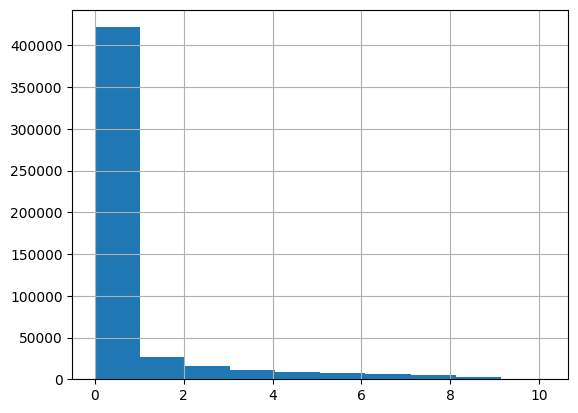

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 53.05it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7815


event   tolerance
onset   12           0.252465
        36           0.691401
        60           0.786997
        90           0.829135
        120          0.846033
        150          0.860220
        180          0.868528
        240          0.882359
        300          0.888509
        360          0.893883
wakeup  12           0.208435
        36           0.710890
        60           0.794229
        90           0.831542
        120          0.849876
        150          0.863791
        180          0.873747
        240          0.889119
        300          0.899122
        360          0.909438
dtype: float64